In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:15pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [57]:
import numpy as np
import pandas as pd
import sys
from tensorflow.keras.utils import to_categorical # utils.to_categorical 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from matplotlib import pyplot as plt # 학습 과정 그래프
from sklearn.metrics import confusion_matrix # 혼동행렬
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split # 데이터 분리

# 이진분류
```
1. 데이터 셋 생성 & 전처리
    엑셀 -> 데이터프레임 -> ?처리(df.replace('?', np.nan) -> 결측치 처리
    -> X,y 분리 -> x변수 스케일 조정 -> train_test_split 함수로 학습셋과 테스트셋 분리
2. 모델 생성(입력 13, 출력1)
3. 모델 평가(그래프, 평가, 교차표)
4. 모델 사용(저장, 예측)
```



## 1. 데이터 셋 생성 & 전처리
    엑셀 -> 데이터프레임 -> ?처리(df.replace('?', np.nan) -> 결측치 처리
    -> X,y 분리 -> x변수 스케일 조정 -> train_test_split 함수로 학습셋과 테스트셋 분리

In [188]:
dataset = pd.read_excel('data/heart-disease.xlsx')
dataset.info()
dataset.isin(['?']).any() # 물음표가 있는 열 여부

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


age             False
sex             False
cp              False
treshtbps       False
chol             True
fbs             False
restecg         False
thalach         False
exang           False
oldpeak         False
slope           False
ca               True
hsl              True
heartDisease    False
dtype: bool

In [189]:
# 물음표 있는 데이터
dataset[(dataset['chol']=='?')|(dataset['ca']=='?')|(dataset['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [190]:
# '?'를 결측치(np.nan)로 대체
df = dataset.replace('?', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [191]:
# 결측치가 포함된 데이터 추출
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [192]:
# 결측치 처리 : 대체 or 제거
df.fillna(value=df.median(), inplace=True) # 결측치를 중위수로 대체
# df = df.dropna(how='any')  #결측치 제거
df.isna().sum() # 결측치가 없는지 확인

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [210]:
dataset.shape
# 데이터 분할 : 학습데이터셋(모델학습용)+시험데이터셋(모델평가용)
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X_scaler = MinMaxScaler()
X_scaled_data = X_scaler.fit_transform(X)
X_scaled_data
# X_train = dataset.iloc[:240, :-1]
# y_train = dataset.iloc[:240, -1]
# X_test  = dataset.iloc[240:, :-1]
# y_test  = dataset.iloc[240:, -1]
# X_train.shape, y_train.shape, X_test.shape, y_test.shape
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_data, y, test_size=0.3, # 테스트셋비율
    random_state=7, shuffle=True
    , stratify=y # 층화추출
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((212, 13), (91, 13), (212,), (91,))

In [211]:
print(pd.DataFrame(y).value_counts(normalize=True)) # 전체 데이터
print(pd.DataFrame(y_train).value_counts(normalize=True)) # 전체 데이터
print(pd.DataFrame(y_test).value_counts(normalize=True)) # 전체 데이터

0    0.541254
1    0.458746
dtype: float64
0    0.542453
1    0.457547
dtype: float64
0    0.538462
1    0.461538
dtype: float64


## 2. 모델 생성(입력 13, 출력1)

In [223]:
model = Sequential()
model.add(Input(shape=(13,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1,  activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                896       
                                                                 
 dense_61 (Dense)            (None, 128)               8320      
                                                                 
 dense_62 (Dense)            (None, 32)                4128      
                                                                 
 dense_63 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________


In [224]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['binary_accuracy'])

In [225]:
%%time
hist = model.fit(X_train, y_train, # 훈련데이터
                epochs=200, # 학습횟수
                batch_size=350, # 한번에 읽어들이는 데이터 양
                validation_data=(X_test, y_test), # 검증데이터
                validation_split=0.1, 
                verbose=0 # 학습 로그 출력 여부(0:출력X, 1:출력O, 2:출력자세히O)
                )

CPU times: total: 7.62 s
Wall time: 5.6 s


In [226]:
hist.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

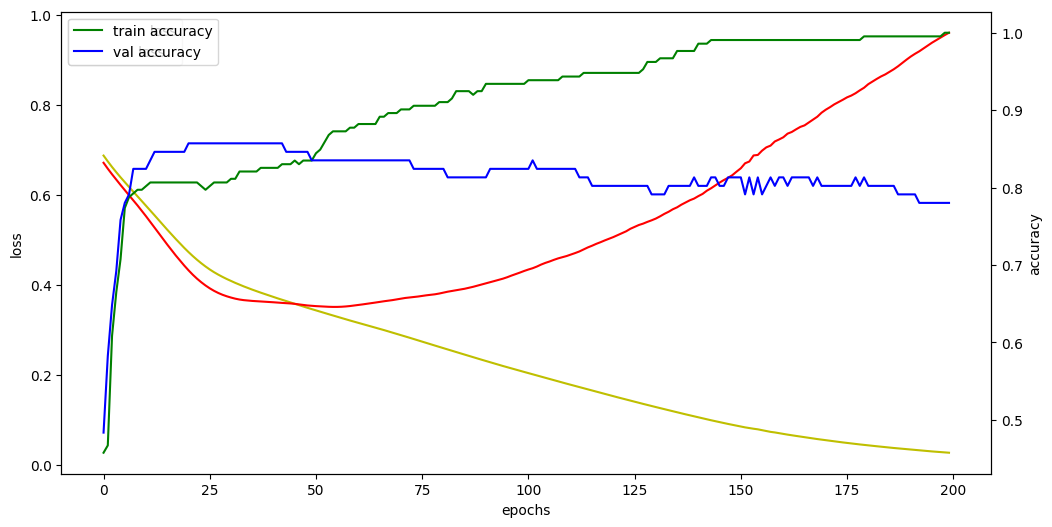

In [227]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['binary_accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_binary_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend()
acc_ax.legend()

In [217]:
# 모델 평가(O)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.3239 - binary_accuracy: 0.8571


[0.32385045289993286, 0.8571428656578064]

### 컬럼명   의미 및 설명

- cp   흉통의 유형 (Chest Pain type)
    - 0: 전형적 협심증 / 1: 비전형적 협심증 / 2: 비심장성 흉통 / 3: 무증상
- treshtbps   안정 시 수축기 혈압 (Resting Blood Pressure in mm Hg)
- chol   혈청 콜레스테롤 수치 (Serum Cholesterol in mg/dl)
- fbs   공복혈당 120mg/dl 이상 여부 (Fasting Blood Sugar) - 1: Yes, 0: No
- restecg   안정 시 심전도 결과 (Resting Electrocardiographic Results)
    - 0: 정상 / 1: ST-T 이상 / 2: 좌심실 비대 가능성
- thalach   최대 심박수 (Maximum Heart Rate Achieved)
- exang   운동 중 협심증 여부 (Exercise Induced Angina) - 1: 있음, 0: 없음
- oldpeak   운동 후 ST 감소 정도 (ST Depression induced by exercise relative to rest)
- slope   ST segment의 기울기 (Slope of the peak exercise ST segment)
    - 1: 수평  / 2: 상승  / 3: 하강
- ca   형광투시검사에서 관찰된 주요 혈관 수 (Number of major vessels colored by fluoroscopy)
- hsl (일반적으로 thal로 표기됨)   지혈소 상태 (Thalassemia)
    - 3: 정상 / 6: 고정결함 / 7: 가역적 결함
- heartDisease   심장병 여부 (Target Variable)
    - 1: 심장병 있음 / 0: 없음

# 분류분석
```
1. 데이터 셋 생성 & 전처리
    엑셀 -> 데이터프레임 -> ?처리(df.replace('?', np.nan) -> 결측치 처리
    -> X,y 분리 -> x변수 스케일 조정 -> train_test_split 함수로 학습셋과 테스트셋 분리
    -> y 변수들의 원핫인코딩
2. 모델 생성(입력 13, 출력2) & 학습과정 설정 & 학습
3. 모델 평가(그래프, 평가, 교차표)
4. 모델 사용(저장, 예측)
```
